In [34]:
using Flux
using Statistics
using Plots

In [35]:
nx = 100
L = 10.0f0
Δx = L/nx
t_end = 5.0f0
nt = 100
Δt = t_end/nt
ν = 0.1f0

x_points = 0.0f0:Float32(Δx):Float32(L) |> collect
t_points = 0.0f0:Float32(Δt):Float32(t_end) |> collect
xts = collect(Iterators.product(x_points, t_points))

u_mean = 1.0
u_amplitude = 0.5
k = 2*pi/L

u0(x) = Float32(u_mean + u_amplitude * cos(k*x));

In [36]:
NN = Chain(
    Dense(2, 32, tanh),
    Dense(32, 32, tanh),
    Dense(32, 1)
) |> f32;

In [38]:
ϵ = sqrt(eps(Float32))
λ = 1.0f0 # Relative strength of the pde regularization

function u_xt(m, x, t)
    xt = reshape(Float32.([x, t]), :, 1)
    m(xt)
end

function loss_pde(m, xts)
    res = ( 
        ( (u_xt(m, x, t+ϵ)[1] - u_xt(m, x, t)[1]) / ϵ ) +                # dudt
        u_xt(m, x, t)[1] * ( (u_xt(m, x+ϵ, t)[1] - u_xt(m, x, t)[1]) / ϵ ) -  # u * dudx
        ν * ( (u_xt(m, x+ϵ, t)[1] - 2u_xt(m, x, t)[1] + u_xt(m, x-ϵ, t)[1]) / (ϵ^2) )   # -ν d2udx2
        for (x,t) in xts
    )
    mean(abs2, res)
end
function loss_ic(m, x_points)
    mean(abs2, ((u_xt(m, x, 0f0)[1] - u0(x)) for x in x_points)) 
end
function loss_bc(m, t_points, L)
    mean(abs2, ((u_xt(m, 0f0, t)[1] - u_xt(m, L, t)[1]) for t in t_points))
end

function total_loss(m, x_points, t_points, xts, L)
    loss_ic(m, x_points) + loss_bc(m, t_points, L) + λ * loss_pde(m, xts)
end;

In [39]:
# Optimiser + state
opt = Flux.Optimisers.Descent(0.01)
state = Flux.setup(opt, NN);

In [40]:
# Training loop
losses = []
for epoch in 1:100
    val, grad = Flux.withgradient(NN) do m
        total_loss(m, x_points, t_points, xts, L)
    end
    push!(losses, val)
    Flux.update!(state, NN, grad[1])
    
    if epoch % 10 == 0
        println("Epoch=$epoch, loss=$(val)")
    end
end

Epoch=10, loss=0.32102937
Epoch=20, loss=0.25690773
Epoch=30, loss=0.22769745
Epoch=40, loss=0.2015753
Epoch=50, loss=0.18519235
Epoch=60, loss=0.17053288
Epoch=70, loss=0.15945137
Epoch=80, loss=0.14811555
Epoch=90, loss=0.14268085
Epoch=100, loss=0.13115013


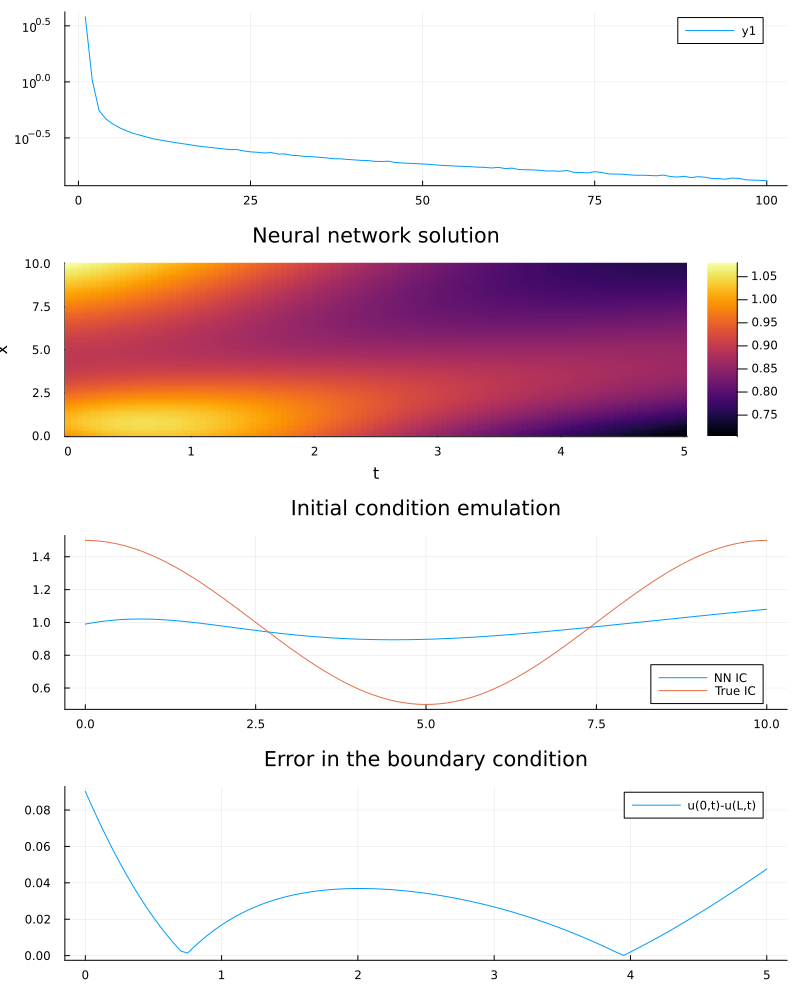

In [41]:
us = zeros((size(xts,1), size(xts,2)))
for j in 1:size(xts,2), i in 1:size(xts,1)
    xt = xts[i,j]
    us[i,j] = u_xt(NN, xt[1], xt[2])[1]
end

ic = us[:,1]
bc = abs.(us[1,:] .- us[end,:])

p0 = plot(losses, yscale=:log10)
p1 = heatmap(t_points, x_points, us, xlabel="t", ylabel='x', title="Neural network solution")
p2 = plot(x_points, ic, label="NN IC")
plot!(p2, x_points, u0.(x_points), label="True IC", title="Initial condition emulation")
p3 = plot(t_points, bc, label="u(0,t)-u(L,t)", title="Error in the boundary condition")
plot(p0, p1, p2, p3, layout=(4,1), size=(800,1000))

[ Info: Saved animation to /home/mlenes/Code/surrogate_flow/emulated_burgers.gif


Plots.AnimatedGif("/home/mlenes/Code/surrogate_flow/emulated_burgers.gif")
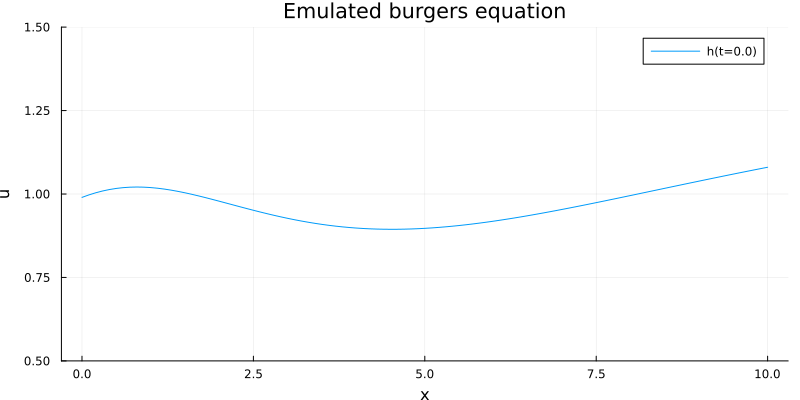

In [42]:
anim = @animate for i in 1:length(t_points)
    p1 = plot(x_points, us[:,i], label="h(t=$(round(t_points[i],digits=2)))", xlabel='x', ylabel='u', ylim=(u_mean-u_amplitude, u_mean+u_amplitude))
    plot(p1, size=(800,400), title="Emulated burgers equation")
end
gif(anim, "emulated_burgers.gif", fps=15)